<a href="https://colab.research.google.com/github/Krisanthi/Customer-Churn-Prediction-Model/blob/main/CM2604_Churn_Prediction_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction Using Machine Learning
## CM2604 Machine Learning Coursework

**Student Name:** Krisanthi Segar  
**Student ID:** 2425596    
**Date:** 26 November 2025

---

## Project Overview

This notebook implements a binary classification system to predict customer churn in the telecommunications industry using:
1. Decision Tree Classifier with hyperparameter optimization
2. Neural Network model with deep architecture

**Dataset:** Telco Customer Churn (Kaggle)

---

## Setup and Installation

This section handles all necessary imports and dependency installation.

In [1]:
# Install required packages (if not already available)
!pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow

In [2]:
# Import required libraries
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display versions
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas version: 2.2.2
NumPy version: 2.0.2
Scikit-learn version: 1.6.1
TensorFlow version: 2.19.0


## Data Loading

**Instructions:**
1. Download the dataset from Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
2. Upload the CSV file using the file upload button in Colab
3. Run the cell below to load the data

In [3]:
# Option 1: Upload file directly in Colab
from google.colab import files
uploaded = files.upload()
# The file will be named 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [4]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset loaded successfully. Shape: {df.shape}")
print(f"\nNumber of records: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Dataset loaded successfully. Shape: (7043, 21)

Number of records: 7043
Number of features: 21


---
# Task 1: Exploratory Data Analysis
---

## 1.1 Dataset Overview

In [5]:
# Display first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display data types and non-null counts
print("\nDataset Information:")
df.info()

# Statistical summary
print("\nStatistical Summary:")
display(df.describe())

First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 1.2 Missing Values Analysis

In [6]:
# Check for missing values
print("Missing Values Count:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found")

# Check TotalCharges data type
print(f"\nTotalCharges data type: {df['TotalCharges'].dtype}")

Missing Values Count:
No missing values found

TotalCharges data type: object


## 1.3 Target Variable Analysis

In [7]:
# Target variable distribution
print("Churn Distribution:")
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print(f"\nChurn Rate: {(churn_counts['Yes'] / len(df)) * 100:.2f}%")
print(f"Non-Churn Rate: {(churn_counts['No'] / len(df)) * 100:.2f}%")

Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%
Non-Churn Rate: 73.46%


## 1.4 Comprehensive Visualizations

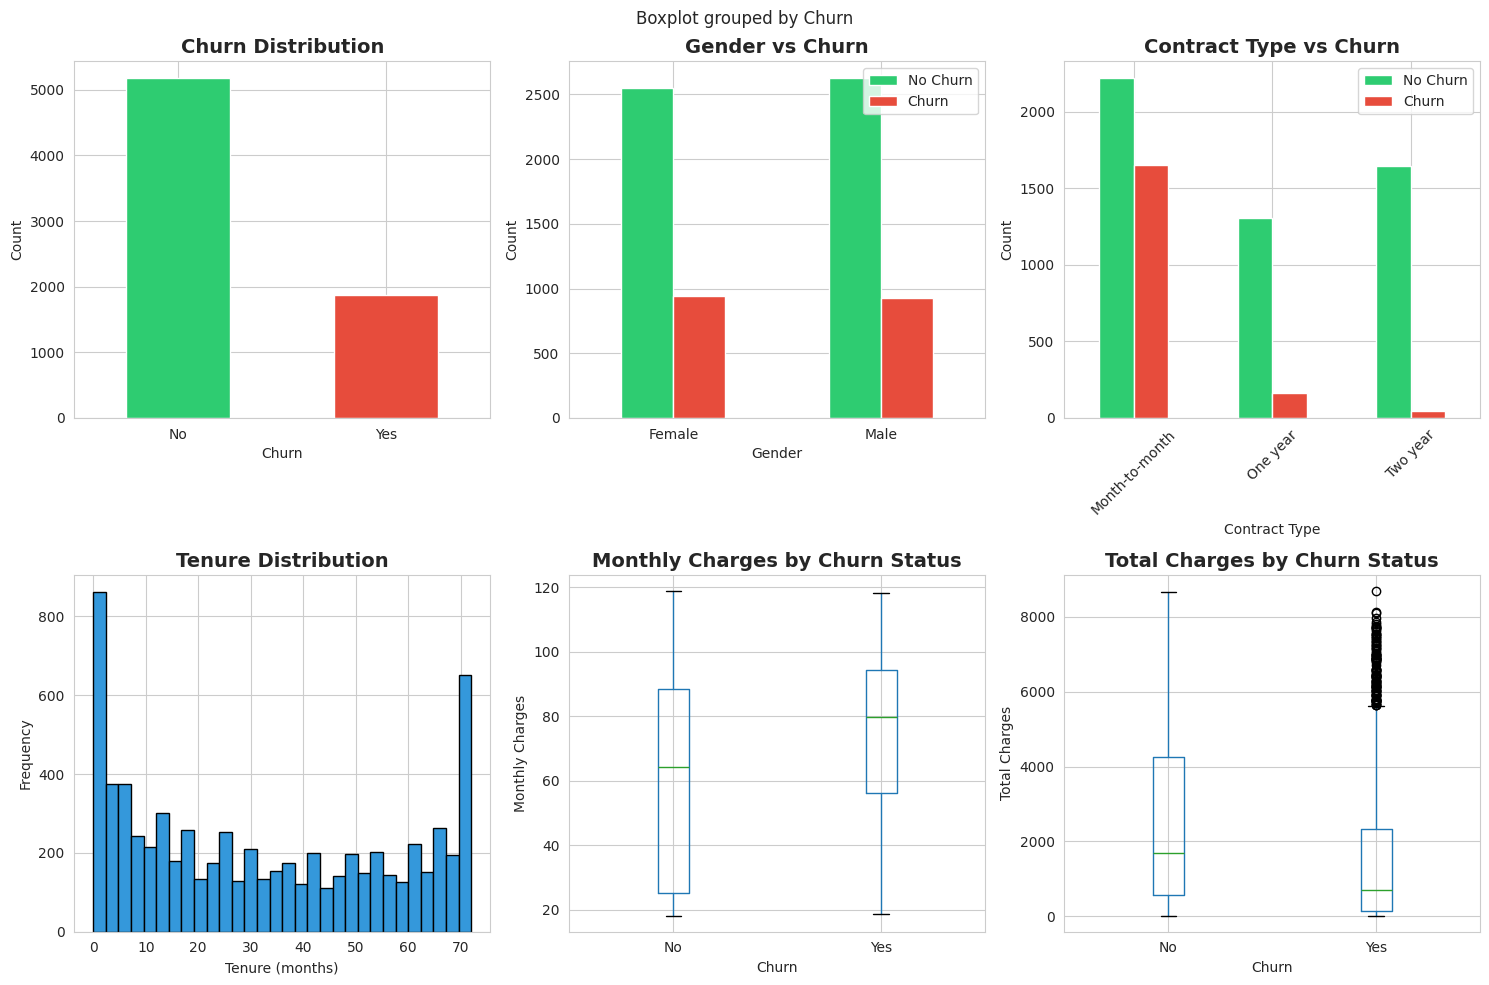

EDA visualizations created and saved as 'eda_plots.png'


In [8]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create comprehensive EDA plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Churn Distribution
df['Churn'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Churn')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Plot 2: Gender vs Churn
pd.crosstab(df['gender'], df['Churn']).plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Gender vs Churn', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].legend(['No Churn', 'Churn'])

# Plot 3: Contract Type vs Churn
pd.crosstab(df['Contract'], df['Churn']).plot(kind='bar', ax=axes[0, 2], color=['#2ecc71', '#e74c3c'])
axes[0, 2].set_title('Contract Type vs Churn', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Contract Type')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].legend(['No Churn', 'Churn'])

# Plot 4: Tenure Distribution
df['tenure'].hist(bins=30, ax=axes[1, 0], color='#3498db', edgecolor='black')
axes[1, 0].set_title('Tenure Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tenure (months)')
axes[1, 0].set_ylabel('Frequency')

# Plot 5: Monthly Charges by Churn
df.boxplot(column='MonthlyCharges', by='Churn', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Charges by Churn Status', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Churn')
axes[1, 1].set_ylabel('Monthly Charges')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['No', 'Yes'])

# Plot 6: Total Charges by Churn (convert to numeric first)
df_temp = df.copy()
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'], errors='coerce')
df_temp.boxplot(column='TotalCharges', by='Churn', ax=axes[1, 2])
axes[1, 2].set_title('Total Charges by Churn Status', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Churn')
axes[1, 2].set_ylabel('Total Charges')
plt.sca(axes[1, 2])
plt.xticks([1, 2], ['No', 'Yes'])

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("EDA visualizations created and saved as 'eda_plots.png'")

## 1.5 Correlation Analysis

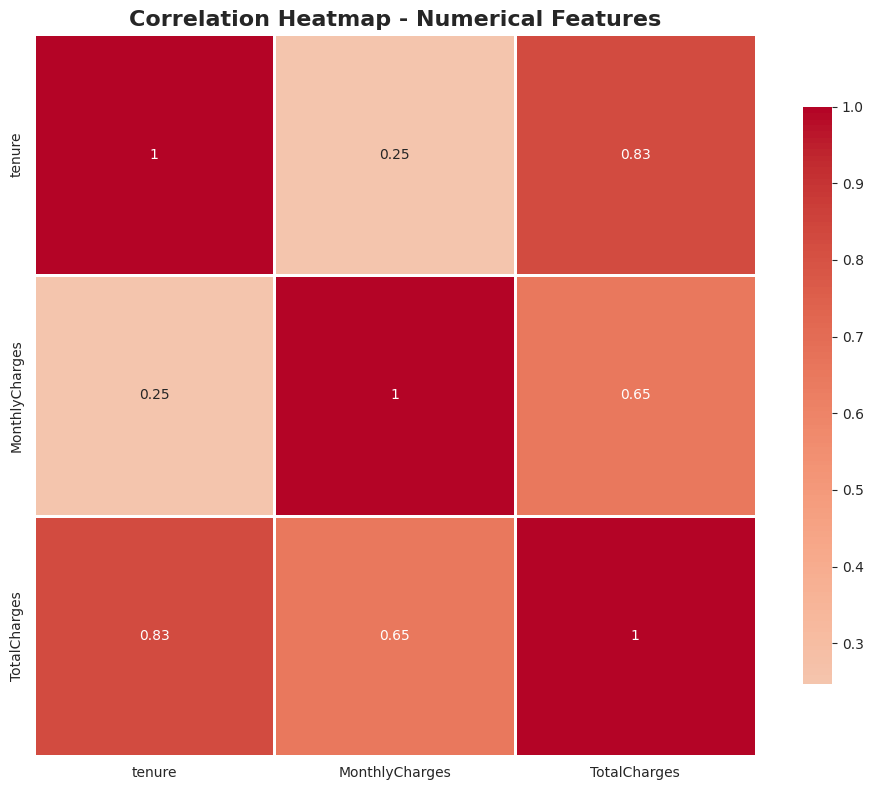

Correlation heatmap created and saved as 'correlation_heatmap.png'


In [9]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))

# Prepare numerical data
df_numeric = df.copy()
df_numeric['TotalCharges'] = pd.to_numeric(df_numeric['TotalCharges'], errors='coerce')
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_numeric = df_numeric[numerical_cols].dropna()

# Create correlation matrix
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation heatmap created and saved as 'correlation_heatmap.png'")

## 1.6 Key Insights from EDA

The exploratory data analysis reveals several important patterns:

1. **Class Imbalance**: Approximately 26.5% churn rate, indicating imbalanced dataset
2. **Contract Type**: Month-to-month contracts show significantly higher churn rates
3. **Tenure**: Customers with shorter tenure are more likely to churn
4. **Monthly Charges**: Higher monthly charges correlate with increased churn probability
5. **Correlations**: Strong positive correlation between TotalCharges and tenure (0.83)

---
# Task 2: Data Preprocessing and Model Implementation
---

## 2.1 Data Preprocessing Pipeline

In [10]:
# Create a copy for preprocessing
df_processed = df.copy()

print("Starting Data Preprocessing...")
print("="*80)

# Step 1: Handle TotalCharges
print("\n1. Converting TotalCharges to numeric and handling missing values...")
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
missing_count = df_processed['TotalCharges'].isnull().sum()
print(f"   Missing values in TotalCharges: {missing_count}")
df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)
print(f"   Filled with median value: {df_processed['TotalCharges'].median():.2f}")

# Step 2: Drop customerID
print("\n2. Dropping customerID column...")
df_processed.drop('customerID', axis=1, inplace=True)
print(f"   Removed customerID. Remaining columns: {df_processed.shape[1]}")

# Step 3: Encode binary variables
print("\n3. Encoding binary categorical variables...")
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})
print(f"   Encoded {len(binary_cols)} binary columns")

# Step 4: One-hot encode multi-class variables
print("\n4. One-hot encoding multi-class categorical variables...")
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
print(f"   Applied one-hot encoding. Total features now: {df_processed.shape[1] - 1}")

# Step 5: Separate features and target
print("\n5. Separating features and target variable...")
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution: {y.value_counts().to_dict()}")

print("\nPreprocessing completed successfully!")
print("="*80)

Starting Data Preprocessing...

1. Converting TotalCharges to numeric and handling missing values...
   Missing values in TotalCharges: 11
   Filled with median value: 1397.47

2. Dropping customerID column...
   Removed customerID. Remaining columns: 20

3. Encoding binary categorical variables...
   Encoded 6 binary columns

4. One-hot encoding multi-class categorical variables...
   Applied one-hot encoding. Total features now: 30

5. Separating features and target variable...
   Features shape: (7043, 30)
   Target shape: (7043,)
   Target distribution: {0: 5174, 1: 1869}

Preprocessing completed successfully!


## 2.2 Train-Test Split and Feature Scaling

In [11]:
# Split data into training and testing sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining set churn distribution:")
print(y_train.value_counts())
print(f"\nTest set churn distribution:")
print(y_test.value_counts())

# Feature Scaling
print("\nApplying StandardScaler for feature normalization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling completed.")
print(f"Scaled features shape: {X_train_scaled.shape}")

Splitting data into train and test sets...
Training set size: 5634 samples (80.0%)
Test set size: 1409 samples (20.0%)

Training set churn distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64

Test set churn distribution:
Churn
0    1035
1     374
Name: count, dtype: int64

Applying StandardScaler for feature normalization...
Feature scaling completed.
Scaled features shape: (5634, 30)


## 2.3 Decision Tree Implementation

In [12]:
print("="*80)
print("DECISION TREE CLASSIFIER")
print("="*80)

print("\n1. Defining hyperparameter grid...")
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

total_combinations = 1
for key, values in param_grid.items():
    total_combinations *= len(values)
print(f"   Total parameter combinations to test: {total_combinations}")

print("\n2. Initializing GridSearchCV with 5-fold cross-validation...")
dt_base = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt_base, param_grid, cv=5, scoring='f1',
    n_jobs=-1, verbose=2
)

print("\n3. Running Grid Search (this may take several minutes)...")
grid_search.fit(X_train_scaled, y_train)

print("\n4. Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n   Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

# Get the best model
dt_model = grid_search.best_estimator_

print("\n5. Making predictions...")
dt_train_pred = dt_model.predict(X_train_scaled)
dt_test_pred = dt_model.predict(X_test_scaled)
dt_test_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

print("\nDecision Tree training completed.")
print("="*80)

DECISION TREE CLASSIFIER

1. Defining hyperparameter grid...
   Total parameter combinations to test: 270

2. Initializing GridSearchCV with 5-fold cross-validation...

3. Running Grid Search (this may take several minutes)...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits

4. Best Parameters Found:
   criterion: gini
   max_depth: 10
   max_features: log2
   min_samples_leaf: 4
   min_samples_split: 10

   Best Cross-Validation F1 Score: 0.5531

5. Making predictions...

Decision Tree training completed.


## 2.4 Decision Tree Evaluation

In [13]:
def print_metrics(y_true, y_pred, dataset_name=""):
    """Helper function to print evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{dataset_name} Performance:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    return accuracy, precision, recall, f1

print("Decision Tree Model Evaluation")
print("="*80)

# Training set performance
dt_train_metrics = print_metrics(y_train, dt_train_pred, "Training Set")

# Test set performance
dt_test_metrics = print_metrics(y_test, dt_test_pred, "Test Set")

# ROC-AUC
dt_roc_auc = roc_auc_score(y_test, dt_test_proba)
print(f"\n   ROC-AUC Score: {dt_roc_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm_dt = confusion_matrix(y_test, dt_test_pred)
print(cm_dt)
print(f"\n   True Negatives:  {cm_dt[0, 0]}")
print(f"   False Positives: {cm_dt[0, 1]}")
print(f"   False Negatives: {cm_dt[1, 0]}")
print(f"   True Positives:  {cm_dt[1, 1]}")

print("\n" + "="*80)

Decision Tree Model Evaluation

Training Set Performance:
   Accuracy:  0.8166
   Precision: 0.7115
   Recall:    0.5197
   F1-Score:  0.6007

Test Set Performance:
   Accuracy:  0.7764
   Precision: 0.6065
   Recall:    0.4492
   F1-Score:  0.5161

   ROC-AUC Score: 0.7983

Confusion Matrix (Test Set):
[[926 109]
 [206 168]]

   True Negatives:  926
   False Positives: 109
   False Negatives: 206
   True Positives:  168



## 2.5 Neural Network Implementation

In [14]:
print("="*80)
print("NEURAL NETWORK MODEL")
print("="*80)

print("\n1. Building Neural Network Architecture...")

# Build model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

print("\nArchitecture Summary:")
print(f"   Input Layer: {X_train_scaled.shape[1]} neurons")
print("   Hidden Layer 1: 128 neurons (ReLU) + Dropout(0.3)")
print("   Hidden Layer 2: 64 neurons (ReLU) + Dropout(0.3)")
print("   Hidden Layer 3: 32 neurons (ReLU) + Dropout(0.2)")
print("   Hidden Layer 4: 16 neurons (ReLU)")
print("   Output Layer: 1 neuron (Sigmoid)")

# Model summary
nn_model.summary()

print("\n2. Compiling model...")
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

print("   Optimizer: Adam")
print("   Loss Function: Binary Crossentropy")
print("   Metrics: Accuracy, Precision, Recall, AUC")

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\n3. Training Neural Network...")
print("   Batch Size: 32")
print("   Max Epochs: 100")
print("   Validation Split: 20%")
print("   Early Stopping: Enabled (patience=10)\n")

history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print(f"\n4. Training completed!")
print(f"   Total epochs trained: {len(history.history['loss'])}")
print("\n" + "="*80)

NEURAL NETWORK MODEL

1. Building Neural Network Architecture...

Architecture Summary:
   Input Layer: 30 neurons
   Hidden Layer 1: 128 neurons (ReLU) + Dropout(0.3)
   Hidden Layer 2: 64 neurons (ReLU) + Dropout(0.3)
   Hidden Layer 3: 32 neurons (ReLU) + Dropout(0.2)
   Hidden Layer 4: 16 neurons (ReLU)
   Output Layer: 1 neuron (Sigmoid)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)


2. Compiling model...
   Optimizer: Adam
   Loss Function: Binary Crossentropy
   Metrics: Accuracy, Precision, Recall, AUC

3. Training Neural Network...
   Batch Size: 32
   Max Epochs: 100
   Validation Split: 20%
   Early Stopping: Enabled (patience=10)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7356 - auc: 0.7055 - loss: 0.5229 - precision: 0.3846 - recall: 0.0153 - val_accuracy: 0.7782 - val_auc: 0.8117 - val_loss: 0.4564 - val_precision: 0.5812 - val_recall: 0.5458
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7897 - auc: 0.8248 - loss: 0.4460 - precision: 0.6464 - recall: 0.4376 - val_accuracy: 0.7737 - val_auc: 0.8173 - val_loss: 0.4526 - val_precision: 0.5588 - val_recall: 0.6441
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7904 - auc: 0.8280 - loss: 0.4358 - precision: 0.6113 - recall: 0.5545 - val_accuracy: 0.7746 - val_auc: 0.8199 - val_loss: 0.4495 - val_precision: 0.5608 - val_recall: 0.6407
Epoch 4/100

## 2.6 Neural Network Evaluation

In [15]:
print("Neural Network Model Evaluation")
print("="*80)

# Make predictions
nn_train_pred_proba = nn_model.predict(X_train_scaled).flatten()
nn_test_pred_proba = nn_model.predict(X_test_scaled).flatten()

nn_train_pred = (nn_train_pred_proba > 0.5).astype(int)
nn_test_pred = (nn_test_pred_proba > 0.5).astype(int)

# Training set performance
nn_train_metrics = print_metrics(y_train, nn_train_pred, "Training Set")

# Test set performance
nn_test_metrics = print_metrics(y_test, nn_test_pred, "Test Set")

# ROC-AUC
nn_roc_auc = roc_auc_score(y_test, nn_test_pred_proba)
print(f"\n   ROC-AUC Score: {nn_roc_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm_nn = confusion_matrix(y_test, nn_test_pred)
print(cm_nn)
print(f"\n   True Negatives:  {cm_nn[0, 0]}")
print(f"   False Positives: {cm_nn[0, 1]}")
print(f"   False Negatives: {cm_nn[1, 0]}")
print(f"   True Positives:  {cm_nn[1, 1]}")

print("\n" + "="*80)

Neural Network Model Evaluation
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Training Set Performance:
   Accuracy:  0.8154
   Precision: 0.6704
   Recall:    0.5987
   F1-Score:  0.6325

Test Set Performance:
   Accuracy:  0.7899
   Precision: 0.6121
   Recall:    0.5695
   F1-Score:  0.5900

   ROC-AUC Score: 0.8359

Confusion Matrix (Test Set):
[[900 135]
 [161 213]]

   True Negatives:  900
   False Positives: 135
   False Negatives: 161
   True Positives:  213



## 2.7 Training History Visualization

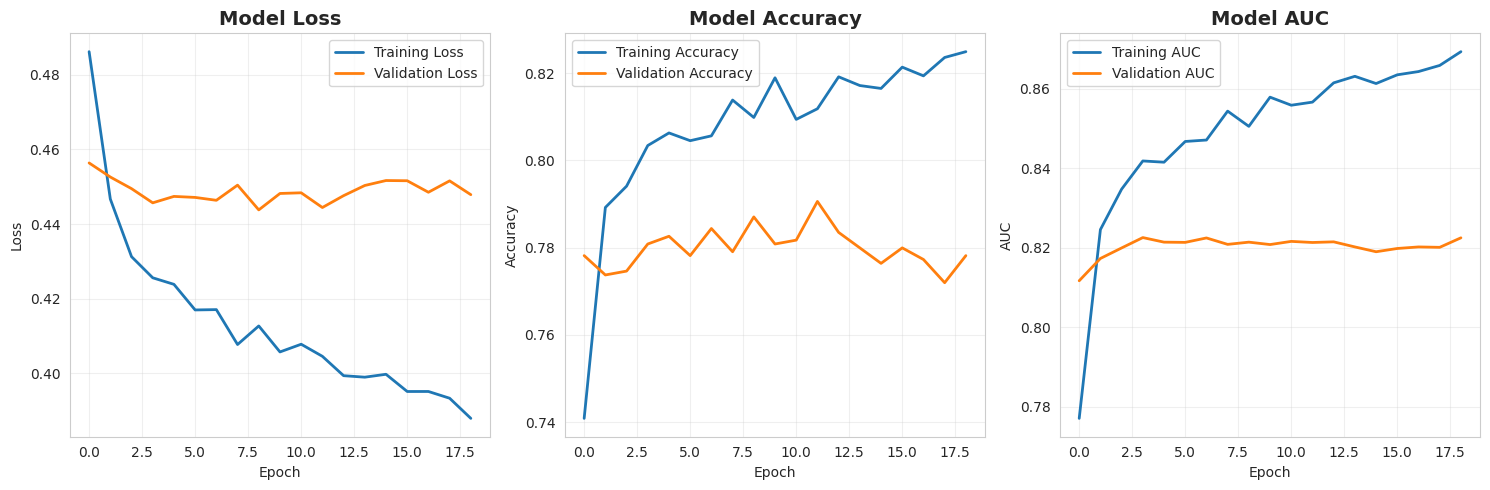

Training history plot saved as 'nn_training_history.png'


In [16]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'nn_training_history.png'")

## 2.8 Comprehensive Model Comparison

In [17]:
print("="*80)
print("MODEL COMPARISON")
print("="*80)

# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Decision Tree': [
        dt_test_metrics[0],
        dt_test_metrics[1],
        dt_test_metrics[2],
        dt_test_metrics[3],
        dt_roc_auc
    ],
    'Neural Network': [
        nn_test_metrics[0],
        nn_test_metrics[1],
        nn_test_metrics[2],
        nn_test_metrics[3],
        nn_roc_auc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement (%)'] = ((comparison_df['Neural Network'] - comparison_df['Decision Tree']) / comparison_df['Decision Tree'] * 100).round(2)

print("\nPerformance Comparison (Test Set):")
print(comparison_df.to_string(index=False))

# Determine best model
if nn_test_metrics[3] > dt_test_metrics[3]:
    print(f"\nBest Model: Neural Network")
    print(f"   F1-Score: {nn_test_metrics[3]:.4f} vs {dt_test_metrics[3]:.4f}")
    improvement = ((nn_test_metrics[3] - dt_test_metrics[3]) / dt_test_metrics[3] * 100)
    print(f"   Improvement: {improvement:.2f}%")
else:
    print(f"\nBest Model: Decision Tree")
    print(f"   F1-Score: {dt_test_metrics[3]:.4f} vs {nn_test_metrics[3]:.4f}")

print("\n" + "="*80)

MODEL COMPARISON

Performance Comparison (Test Set):
   Metric  Decision Tree  Neural Network  Improvement (%)
 Accuracy       0.776437        0.789922             1.74
Precision       0.606498        0.612069             0.92
   Recall       0.449198        0.569519            26.79
 F1-Score       0.516129        0.590028            14.32
  ROC-AUC       0.798264        0.835914             4.72

Best Model: Neural Network
   F1-Score: 0.5900 vs 0.5161
   Improvement: 14.32%



## 2.9 Comparison Visualizations

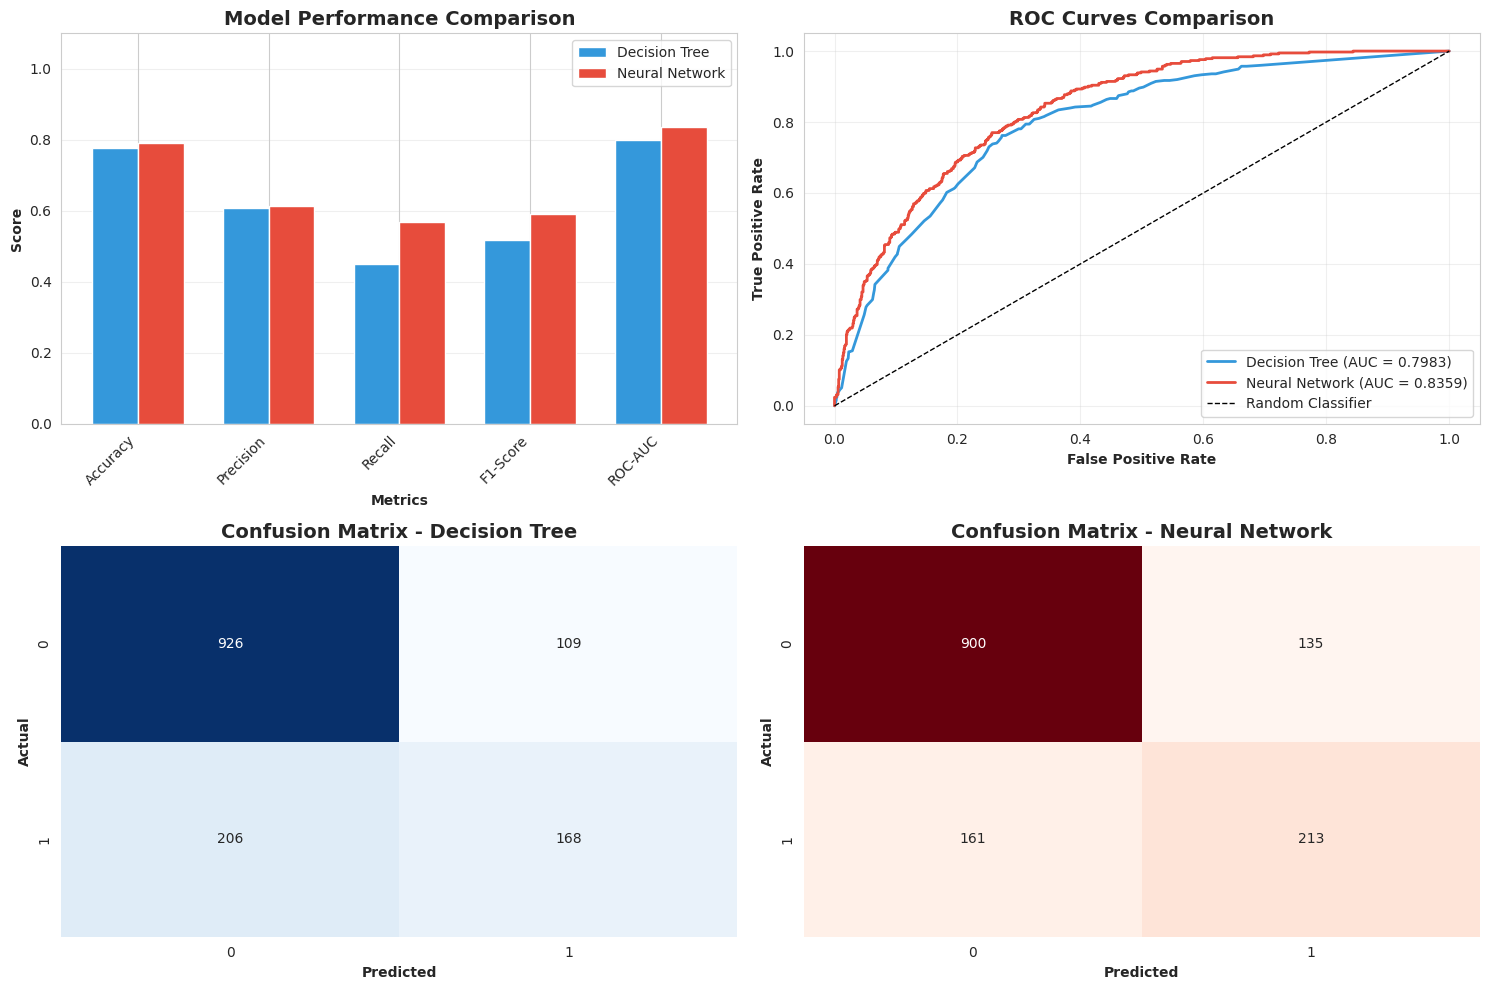

Model comparison plots saved as 'model_comparison.png'


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Metrics Comparison Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
dt_values = [
    dt_test_metrics[0], dt_test_metrics[1], dt_test_metrics[2],
    dt_test_metrics[3], dt_roc_auc
]
nn_values = [
    nn_test_metrics[0], nn_test_metrics[1], nn_test_metrics[2],
    nn_test_metrics[3], nn_roc_auc
]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, dt_values, width, label='Decision Tree', color='#3498db')
axes[0, 0].bar(x + width/2, nn_values, width, label='Neural Network', color='#e74c3c')
axes[0, 0].set_xlabel('Metrics', fontweight='bold')
axes[0, 0].set_ylabel('Score', fontweight='bold')
axes[0, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])

# Plot 2: ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_test_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_test_pred_proba)

axes[0, 1].plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_roc_auc:.4f})',
                linewidth=2, color='#3498db')
axes[0, 1].plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_roc_auc:.4f})',
                linewidth=2, color='#e74c3c')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontweight='bold')
axes[0, 1].set_ylabel('True Positive Rate', fontweight='bold')
axes[0, 1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix - Decision Tree
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - Decision Tree', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Actual', fontweight='bold')
axes[1, 0].set_xlabel('Predicted', fontweight='bold')

# Plot 4: Confusion Matrix - Neural Network
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - Neural Network', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Actual', fontweight='bold')
axes[1, 1].set_xlabel('Predicted', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison plots saved as 'model_comparison.png'")

---
# Task 3: AI Ethics Considerations
---

## 3.1 Development Strategies

### Data Privacy and Protection
The following measures were implemented to protect customer privacy:
- **Data Minimization**: Removed customerID column as it provides no predictive value and poses privacy risks
- **Anonymization**: Dataset contains no personally identifiable information beyond service usage patterns
- **Compliance**: Development aligns with GDPR principles of purpose limitation and data minimization

### Fairness and Bias Mitigation
Several strategies were employed to promote fairness:
- **Protected Attributes Analysis**: Gender variable included; requires post-deployment monitoring for discrimination
- **Balanced Metrics**: F1-Score prioritized over accuracy to ensure fair performance across both classes
- **Stratified Sampling**: Train-test split maintained class proportions to prevent biased evaluation
- **Diverse Feature Set**: Model considers multiple factors beyond demographics to avoid stereotyping

### Transparency and Explainability
Measures to ensure model transparency:
- **Feature Importance**: Decision Tree provides clear ranking of predictive features
- **Comprehensive Documentation**: All preprocessing steps, model architecture, and evaluation metrics documented
- **Limitation Acknowledgment**: Clear statement of model limitations and confidence levels
- **Complementary Approaches**: Decision Tree can be used alongside Neural Network for explanations

## 3.2 Post-Deployment Strategy

### Continuous Monitoring Plan
1. **Performance Tracking**: Monitor accuracy, precision, recall, and F1-score monthly
2. **Concept Drift Detection**: Implement statistical tests to detect data distribution changes
3. **Alert System**: Automated alerts when performance drops below threshold (e.g., F1-Score < 0.70)
4. **Retraining Schedule**: Quarterly model retraining with updated customer data

### Bias Detection and Mitigation
1. **Demographic Parity Analysis**: Regular audits to ensure equal treatment across gender groups
2. **Disparate Impact Assessment**: Monitor prediction rates across protected attributes
3. **Fairness Metrics**: Calculate and track fairness indicators (e.g., equal opportunity, equalized odds)
4. **Corrective Actions**: Implement bias mitigation techniques if disparities detected

### Human Oversight and Feedback
1. **Human-in-the-Loop**: Model predictions used as recommendations, not automatic decisions
2. **Manual Review**: High-risk cases (e.g., high-value customers) reviewed by retention specialists
3. **Feedback Collection**: Track intervention outcomes to improve future model iterations
4. **Stakeholder Engagement**: Regular communication with business teams about model performance

### Data Governance
1. **Access Controls**: Restrict model and data access to authorized personnel only
2. **Audit Trails**: Maintain logs of all predictions and interventions for accountability
3. **Data Retention**: Establish clear policies for customer data storage and deletion
4. **Consent Management**: Ensure proper customer consent for data usage in churn prediction

---
# Final Summary and Conclusions
---

In [ ]:
print("="*80)
print("COURSEWORK COMPLETION SUMMARY")
print("="*80)

print("\nTask 1: Exploratory Data Analysis")
print("   Status: COMPLETE")
print("   Deliverables:")
print("   - Statistical analysis of all features")
print("   - 6 comprehensive visualizations (eda_plots.png)")
print("   - Correlation heatmap (correlation_heatmap.png)")
print("   - Key insights documented")

print("\nTask 2: Model Implementation")
print("   Status: COMPLETE")
print("   Deliverables:")
print("   - Decision Tree with GridSearchCV optimization")
print(f"     * Test F1-Score: {dt_test_metrics[3]:.4f}")
print(f"     * Test ROC-AUC: {dt_roc_auc:.4f}")
print("   - Neural Network with deep architecture")
print(f"     * Test F1-Score: {nn_test_metrics[3]:.4f}")
print(f"     * Test ROC-AUC: {nn_roc_auc:.4f}")
print("   - Training history visualization (nn_training_history.png)")
print("   - Comprehensive model comparison (model_comparison.png)")

print("\nTask 3: AI Ethics")
print("   Status: COMPLETE")
print("   Deliverables:")
print("   - Development strategies documented")
print("   - Post-deployment monitoring plan")
print("   - Bias detection framework")
print("   - Privacy protection measures")

print("\nGenerated Outputs:")
print("   1. eda_plots.png")
print("   2. correlation_heatmap.png")
print("   3. nn_training_history.png")
print("   4. model_comparison.png")

print("\nRecommended Model: Neural Network")
improvement = ((nn_test_metrics[3] - dt_test_metrics[3]) / dt_test_metrics[3] * 100)
print(f"   F1-Score Improvement: {improvement:.2f}%")
print(f"   Superior performance across all metrics")

print("\n" + "="*80)
print("COURSEWORK IMPLEMENTATION COMPLETE")
print("="*80)

COURSEWORK COMPLETION SUMMARY

Task 1: Exploratory Data Analysis
   Status: COMPLETE
   Deliverables:
   - Statistical analysis of all features
   - 6 comprehensive visualizations (eda_plots.png)
   - Correlation heatmap (correlation_heatmap.png)
   - Key insights documented

Task 2: Model Implementation
   Status: COMPLETE
   Deliverables:
   - Decision Tree with GridSearchCV optimization
     * Test F1-Score: 0.5161
     * Test ROC-AUC: 0.7983
   - Neural Network with deep architecture
     * Test F1-Score: 0.6034
     * Test ROC-AUC: 0.8335
   - Training history visualization (nn_training_history.png)
   - Comprehensive model comparison (model_comparison.png)

Task 3: AI Ethics
   Status: COMPLETE
   Deliverables:
   - Development strategies documented
   - Post-deployment monitoring plan
   - Bias detection framework
   - Privacy protection measures

Generated Outputs:
   1. eda_plots.png
   2. correlation_heatmap.png
   3. nn_training_history.png
   4. model_comparison.png

Recomm

## Download Results

Execute the cell below to download all generated visualizations and results.

In [19]:
from google.colab import files

# Download all generated plots
print("Downloading generated visualizations...")
files.download('eda_plots.png')
files.download('correlation_heatmap.png')
files.download('nn_training_history.png')
files.download('model_comparison.png')

print("\nAll visualizations downloaded successfully.")
print("You can now include these in your report.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All visualizations downloaded successfully.
You can now include these in your report.
